In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F

import time
import warnings
warnings.filterwarnings('ignore')
# evaluation
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold

from data_preprocessing_revise import data_processing, split_train_test, input_target, input_target_grouping,input_target_grouping_1d
from model import CustomDataset, train_validation_split

import pandas as pd
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt



In [2]:
file_list = [i.replace('\\','/') for i in sorted(glob(f"c3d/*txt"))]
file_name = []
for i in file_list:
    file, _, _ = os.path.basename(i).split('.')
    file_name.append(file)
    
FORCE, ANGLE, JOINT = data_processing(file_list, file_name)
player_trial, train, test = split_train_test(JOINT, random = 5)
DOM = {}
for session in JOINT:
    if session.split('_')[0] in test:
        df = JOINT[session]
        dominant = df['dominant'][0]
        DOM[session] = dominant


411it [00:18, 21.75it/s]


In [3]:
inputs_sc, targets = input_target(JOINT, FORCE, train, test,joint_cut_off = 13.4, force_cut_off = 60)
model = 'ResNet'
if model == 'Transformer':
    input_target_sc_np = input_target_grouping_1d(inputs_sc, targets)
if model == 'ResNet': 
    input_target_sc_np = input_target_grouping(inputs_sc, targets)

In [4]:
fp = 'lead'
kfolds = KFold(n_splits=9, shuffle=True, random_state=6)
for fold, (t, v) in enumerate(kfolds.split(train)):
    if fold == 1:
        break
    tr = list(np.array(train)[t])
    va = list(np.array(train)[v])
    k_fold_since = time.time()
    train_sessions = list(inputs_sc['train'][fp])
    trn = []
    val = []
    for session in train_sessions:
        if session.split('_')[0] in tr:
            trn.append(session)
        elif session.split('_')[0] in va:
            val.append(session)


In [5]:
test_sessions = []
for i in input_target_sc_np['test']['lead']['input']:
    if i.split('_')[0] in test:
        test_sessions.append(i)

In [24]:
lead_model = torch.load(f'model/{model}-re-lead-best-model.pt', map_location=torch.device('cpu'))
lead_model.load_state_dict(torch.load(f'model/{model}-re-lead-best-model-parameters.pt', map_location=torch.device('cpu')))

lead_train_dataset = {
                'x' : {v : torch.FloatTensor(input_target_sc_np['train']['lead']['input'][v]) for v in trn},
                'y' : {v : torch.FloatTensor(input_target_sc_np['train']['lead']['target'][v]) for v in trn},    
                }
lead_train_loader = {x : DataLoader(CustomDataset(lead_train_dataset['x'][x], lead_train_dataset['y'][x]), batch_size = len(lead_train_dataset['x'][x])) for x in trn}


lead_test_dataset = {
                'x' : {v : torch.FloatTensor(input_target_sc_np['test']['lead']['input'][v]) for v in test_sessions},
                'y' : {v : torch.FloatTensor(input_target_sc_np['test']['lead']['target'][v]) for v in test_sessions},    
                }
lead_test_loader = {x : DataLoader(CustomDataset(lead_test_dataset['x'][x], lead_test_dataset['y'][x]), batch_size = len(lead_test_dataset['x'][x])) for x in test_sessions}

In [25]:
rear_model = torch.load(f'model/{model}-re-rear-best-model.pt', map_location=torch.device('cpu'))
rear_model.load_state_dict(torch.load(f'model/{model}-re-rear-best-model-parameters.pt', map_location=torch.device('cpu')))

rear_train_dataset = {
                'x' : {v : torch.FloatTensor(input_target_sc_np['train']['rear']['input'][v]) for v in trn},
                'y' : {v : torch.FloatTensor(input_target_sc_np['train']['rear']['target'][v]) for v in trn},    
                }
rear_train_loader = {x : DataLoader(CustomDataset(rear_train_dataset['x'][x], rear_train_dataset['y'][x]), batch_size = len(rear_train_dataset['x'][x])) for x in trn}

rear_test_dataset = {
                'x' : {v : torch.FloatTensor(input_target_sc_np['test']['rear']['input'][v]) for v in test_sessions},
                'y' : {v : torch.FloatTensor(input_target_sc_np['test']['rear']['target'][v]) for v in test_sessions},    
                }
rear_test_loader = {x : DataLoader(CustomDataset(rear_test_dataset['x'][x], rear_test_dataset['y'][x]), batch_size = len(rear_test_dataset['x'][x])) for x in test_sessions}

In [26]:
lead_y_true = {}
lead_y_pred = {}
rear_y_true = {}
rear_y_pred = {}
with torch.no_grad():
    lead_model.eval()
    rear_model.eval()
    for session in lead_test_loader:
        for inputs, targets in lead_test_loader[session]:
            lead_outputs = lead_model(inputs)
            lead_y_true[session] = pd.DataFrame(targets.numpy(), columns = ['AP Force','ML Force','Vertical Force'])
            lead_y_pred[session] = pd.DataFrame(lead_outputs.numpy(), columns = ['AP Force','ML Force','Vertical Force'])
    
    for session in rear_test_loader:
        for inputs, targets in rear_test_loader[session]:
            rear_outputs = rear_model(inputs)
            rear_y_true[session] = pd.DataFrame(targets.numpy(), columns = ['AP Force','ML Force','Vertical Force'])
            rear_y_pred[session] = pd.DataFrame(rear_outputs.numpy(), columns = ['AP Force','ML Force','Vertical Force'])

In [30]:
lead_tn_y_true = {}
lead_tn_y_pred = {}
lead_xr = []
lead_yr = []
lead_zr = []
lead_xrmse = []
lead_yrmse = []
lead_zrmse = []
lead_xnrmse = []
lead_ynrmse = []
lead_znrmse = []
smoothing = 1

import scipy.stats as stats
from tnorma import tnorma
for session in test_sessions:
    y_true = lead_y_true[session]
    y_pred = lead_y_pred[session]
    
    trn_y_true, b, a = tnorma(y_true,step=-101)
    lead_tn_y_true[session] = pd.DataFrame(trn_y_true, columns = y_true.columns)
    trn_y_pred, b, a = tnorma(y_pred,step=-101)
    lead_tn_y_pred[session] = pd.DataFrame(trn_y_pred, columns = y_pred.columns)
    
    lead_xr.append(stats.pearsonr(y_true['AP Force'], y_pred['AP Force'].ewm(span=smoothing).mean())[0])
    lead_yr.append(stats.pearsonr(y_true['ML Force'], y_pred['ML Force'].ewm(span=smoothing).mean())[0])
    lead_zr.append(stats.pearsonr(y_true['Vertical Force'], y_pred['Vertical Force'].ewm(span=smoothing).mean())[0])
    
    lead_xrmse.append(mean_squared_error(y_true['AP Force'], y_pred['AP Force'].ewm(span=smoothing).mean(),squared=False))
    lead_yrmse.append(mean_squared_error(y_true['ML Force'], y_pred['ML Force'].ewm(span=smoothing).mean(),squared=False))
    lead_zrmse.append(mean_squared_error(y_true['Vertical Force'], y_pred['Vertical Force'].ewm(span=smoothing).mean(),squared=False))
    
    lead_xnrmse.append(100 * mean_squared_error(y_true['AP Force'], y_pred['AP Force'].ewm(span=smoothing).mean(),squared=False) / (y_true['AP Force'].max() - y_true['AP Force'].min()))
    lead_ynrmse.append(100 * mean_squared_error(y_true['ML Force'], y_pred['ML Force'].ewm(span=smoothing).mean(),squared=False) / (y_true['ML Force'].max() - y_true['ML Force'].min()))
    lead_znrmse.append(100 * mean_squared_error(y_true['Vertical Force'], y_pred['Vertical Force'].ewm(span=smoothing).mean(),squared=False) / (y_true['Vertical Force'].max() - y_true['Vertical Force'].min()))
    
rear_tn_y_true = {}
rear_tn_y_pred = {}
rear_xr = []
rear_yr = []
rear_zr = []
rear_xrmse = []
rear_yrmse = []
rear_zrmse = []
rear_xnrmse = []
rear_ynrmse = []
rear_znrmse = []
smoothing = 1


for session in test_sessions:
    y_true = rear_y_true[session]
    y_pred = rear_y_pred[session]
    
    trn_y_true, b, a = tnorma(y_true,step=-101)
    rear_tn_y_true[session] = pd.DataFrame(trn_y_true, columns = y_true.columns)
    trn_y_pred, b, a = tnorma(y_pred,step=-101)
    rear_tn_y_pred[session] = pd.DataFrame(trn_y_pred, columns = y_pred.columns)
    
    rear_xr.append(stats.pearsonr(y_true['AP Force'], y_pred['AP Force'].ewm(span=smoothing).mean())[0])
    rear_yr.append(stats.pearsonr(y_true['ML Force'], y_pred['ML Force'].ewm(span=smoothing).mean())[0])
    rear_zr.append(stats.pearsonr(y_true['Vertical Force'], y_pred['Vertical Force'].ewm(span=smoothing).mean())[0])
    
    rear_xrmse.append(mean_squared_error(y_true['AP Force'], y_pred['AP Force'].ewm(span=smoothing).mean(),squared=False))
    rear_yrmse.append(mean_squared_error(y_true['ML Force'], y_pred['ML Force'].ewm(span=smoothing).mean(),squared=False))
    rear_zrmse.append(mean_squared_error(y_true['Vertical Force'], y_pred['Vertical Force'].ewm(span=smoothing).mean(),squared=False))
    
    rear_xnrmse.append(100 * mean_squared_error(y_true['AP Force'], y_pred['AP Force'].ewm(span=smoothing).mean(),squared=False) / (y_true['AP Force'].max() - y_true['AP Force'].min()))
    rear_ynrmse.append(100*mean_squared_error(y_true['ML Force'], y_pred['ML Force'].ewm(span=smoothing).mean(),squared=False) / (y_true['ML Force'].max() - y_true['ML Force'].min()))
    rear_znrmse.append(100*mean_squared_error(y_true['Vertical Force'], y_pred['Vertical Force'].ewm(span=smoothing).mean(),squared=False) / (y_true['Vertical Force'].max() - y_true['Vertical Force'].min()))
    

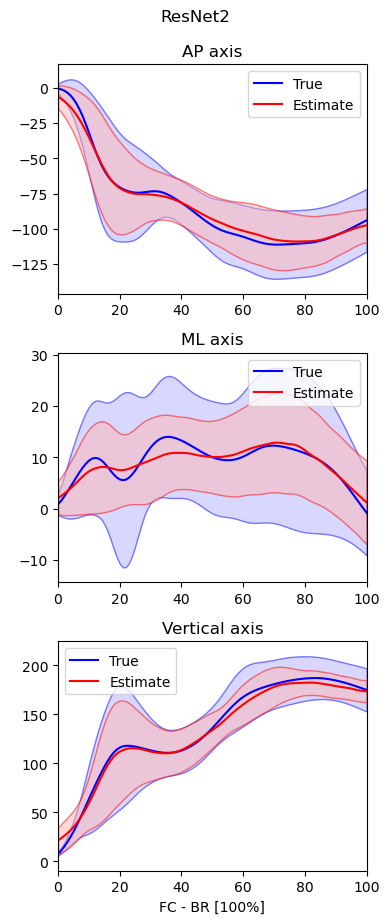

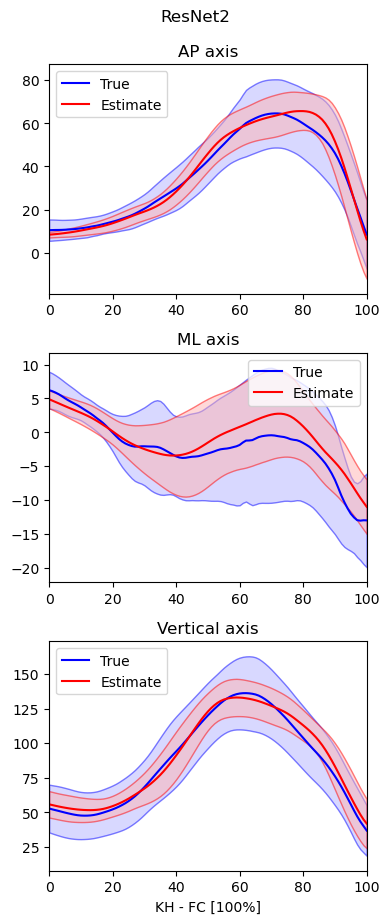

stride
X : RMSE 11.67 (4.89), NRMSE : 10.32 (4.32), R : 0.958 (0.029)
Y : RMSE 8.10 (3.30), NRMSE : 25.22 (8.05), R : 0.642 (0.241)
Z : RMSE 15.85 (5.75), NRMSE : 8.39 (2.77), R : 0.973 (0.016)
drive
X : RMSE 8.23 (3.53), NRMSE : 12.73 (6.80), R : 0.955 (0.058)
Y : RMSE 4.69 (3.12), NRMSE : 18.22 (9.93), R : 0.817 (0.175)
Z : RMSE 13.70 (10.49), NRMSE : 14.33 (14.21), R : 0.964 (0.048)


In [31]:
import spm1d
tn_pred = (np.concatenate([lead_tn_y_pred[session] for session in lead_tn_y_pred], axis=1)).T
tn_true = (np.concatenate([lead_tn_y_true[session] for session in lead_tn_y_true], axis=1)).T

fig, ax = plt.subplots(3,1, figsize= (4,9))
spm1d.plot.plot_mean_sd(tn_true[::3, :], linecolor='b', lw= 1.5,facecolor=(0.7,0.7,1), edgecolor='b', label='True', ax=ax[0])
spm1d.plot.plot_mean_sd(tn_pred[::3, :], linecolor='r', lw= 1.5, facecolor=(1,0.7,0.7), edgecolor='r', label='Estimate', ax=ax[0])
ax[0].legend()
ax[0].set_title('AP axis')
# ax[0].set_ylabel('% BW')
spm1d.plot.plot_mean_sd(tn_true[1::3, :], linecolor='b', lw= 1.5,facecolor=(0.7,0.7,1), edgecolor='b', label='True', ax=ax[1])
spm1d.plot.plot_mean_sd(tn_pred[1::3, :], linecolor='r', lw= 1.5, facecolor=(1,0.7,0.7), edgecolor='r', label='Estimate', ax=ax[1])
ax[1].legend()
ax[1].set_title('ML axis')
# ax[1].set_ylabel('% BW')
spm1d.plot.plot_mean_sd(tn_true[2::3, :], linecolor='b', lw= 1.5,facecolor=(0.7,0.7,1), edgecolor='b', label='True', ax=ax[2])
spm1d.plot.plot_mean_sd(tn_pred[2::3, :], linecolor='r', lw= 1.5, facecolor=(1,0.7,0.7), edgecolor='r', label='Estimate', ax=ax[2])
ax[2].legend()
ax[2].set_title('Vertical axis')
# ax[2].set_ylabel('% BW')
ax[2].set_xlabel('FC - BR [100%]')

plt.tight_layout()
plt.suptitle(f'{model}',y=1.022)
plt.show()

tn_pred = (np.concatenate([rear_tn_y_pred[session] for session in rear_tn_y_pred], axis=1)).T
tn_true = (np.concatenate([rear_tn_y_true[session] for session in rear_tn_y_true], axis=1)).T
fig, ax = plt.subplots(3,1, figsize= (4,9))
spm1d.plot.plot_mean_sd(tn_true[::3, :], linecolor='b', lw= 1.5,facecolor=(0.7,0.7,1), edgecolor='b', label='True', ax=ax[0])
spm1d.plot.plot_mean_sd(tn_pred[::3, :], linecolor='r', lw= 1.5, facecolor=(1,0.7,0.7), edgecolor='r', label='Estimate', ax=ax[0])
ax[0].legend()
ax[0].set_title('AP axis')
# ax[0].set_ylabel('% BW')
spm1d.plot.plot_mean_sd(tn_true[1::3, :], linecolor='b', lw= 1.5,facecolor=(0.7,0.7,1), edgecolor='b', label='True', ax=ax[1])
spm1d.plot.plot_mean_sd(tn_pred[1::3, :], linecolor='r', lw= 1.5, facecolor=(1,0.7,0.7), edgecolor='r', label='Estimate', ax=ax[1])
ax[1].legend()
ax[1].set_title('ML axis')
# ax[1].set_ylabel('% BW')
spm1d.plot.plot_mean_sd(tn_true[2::3, :], linecolor='b', lw= 1.5,facecolor=(0.7,0.7,1), edgecolor='b', label='True', ax=ax[2])
spm1d.plot.plot_mean_sd(tn_pred[2::3, :], linecolor='r', lw= 1.5, facecolor=(1,0.7,0.7), edgecolor='r', label='Estimate', ax=ax[2])
ax[2].legend()
ax[2].set_title('Vertical axis')
# ax[2].set_ylabel('% BW')
ax[2].set_xlabel('KH - FC [100%]')
plt.tight_layout()
plt.show()

print('stride')
print(f"X : RMSE {np.mean(lead_xrmse):.2f} ({np.std(lead_xrmse):.2f}), NRMSE : {np.mean(lead_xnrmse):.2f} ({np.std(lead_xnrmse):.2f}), R : {np.mean(lead_xr):.3f} ({np.std(lead_xr):.3f})")
print(f"Y : RMSE {np.mean(lead_yrmse):.2f} ({np.std(lead_yrmse):.2f}), NRMSE : {np.mean(lead_ynrmse):.2f} ({np.std(lead_ynrmse):.2f}), R : {np.mean(lead_yr):.3f} ({np.std(lead_yr):.3f})")
print(f"Z : RMSE {np.mean(lead_zrmse):.2f} ({np.std(lead_zrmse):.2f}), NRMSE : {np.mean(lead_znrmse):.2f} ({np.std(lead_znrmse):.2f}), R : {np.mean(lead_zr):.3f} ({np.std(lead_zr):.3f})")
print('drive')
print(f"X : RMSE {np.mean(rear_xrmse):.2f} ({np.std(rear_xrmse):.2f}), NRMSE : {np.mean(rear_xnrmse):.2f} ({np.std(rear_xnrmse):.2f}), R : {np.mean(rear_xr):.3f} ({np.std(rear_xr):.3f})")
print(f"Y : RMSE {np.mean(rear_yrmse):.2f} ({np.std(rear_yrmse):.2f}), NRMSE : {np.mean(rear_ynrmse):.2f} ({np.std(rear_ynrmse):.2f}), R : {np.mean(rear_yr):.3f} ({np.std(rear_yr):.3f})")
print(f"Z : RMSE {np.mean(rear_zrmse):.2f} ({np.std(rear_zrmse):.2f}), NRMSE : {np.mean(rear_znrmse):.2f} ({np.std(rear_znrmse):.2f}), R : {np.mean(rear_zr):.3f} ({np.std(rear_zr):.3f})")